In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import re
from datetime import datetime

from Create_Profiles_Functions import *

quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}

def create_dimensionless_event(cumulative_rainfall):

    # Step 3: Normalize the cumulative rainfall by the total event depth
    total_event_depth = cumulative_rainfall[-1]
    normalized_cumulative_rainfall = np.array(cumulative_rainfall) / total_event_depth

    # Step 4: Calculate the cumulative event duration
    # Since each time step is 30 minutes, we multiply the index by 0.5 (for hours)
    time_step = 0.5  # 30 minutes = 0.5 hours
    cumulative_duration = np.arange(1, len(cumulative_rainfall) + 1) * time_step
    
    # Step 5: Normalize the cumulative duration by the total event duration
    total_event_duration = cumulative_duration[-1]
    normalized_cumulative_duration = cumulative_duration / total_event_duration
    normalized_cumulative_rainfall, 
    return normalized_cumulative_rainfall, normalized_cumulative_duration

def redistribute(array_in,len_out):
    len_in=len(array_in)
    # Array going from 0 up to and including the number of original points
    in_bounds=np.arange(len_in+1)
    # Calculates the total accumulated value at each original point
    # Adds a zero for point zero
    csum=np.cumsum(np.hstack((np.array([0.]),array_in)))
    # Array of the "time points" corresponding to
    # Boundaries of output intervals
    out_bounds=np.arange(len_out+1)*(len_in/(1.0*len_out))
    # Interpolate total accumulated value to desired output points
    csum_out=np.interp(out_bounds,in_bounds,csum)
    # Interpolate back to accumulations over the desired number of intervals
    array_out=csum_out[1:]-csum_out[:-1]
    return array_out

### Get a rainfall event

In [18]:
gauge_num =1 
fp = '/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/NIMROD_2.2km_filtered_100/1/WholeYear/0.5hrs_2006_v2_part0.csv'
this_event = read_event(gauge_num, fp)
trimmed_event = remove_leading_and_trailing_zeroes(this_event)
real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)
len(real_trimmed_event)

3

In [3]:
gauge_num =1 
fp = '/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/NIMROD_2.2km_filtered_100/1292/WholeYear/6hrs_2020_v2_part0.csv'
this_event = read_event(gauge_num, fp)
trimmed_event = remove_leading_and_trailing_zeroes(this_event)
real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)
len(real_trimmed_event)

31

## Get a dimensionless version of event and plot

In [19]:
precip = real_trimmed_event['precipitation (mm)']
cumulative_rainfall = create_cumulative_event(precip)
dimensionless_cumulative_rainfall, dimensionless_cumulative_duration = create_dimensionless_event(cumulative_rainfall)
dimensionless_incremental_rainfall  = create_incremental_event(dimensionless_cumulative_rainfall)

In [20]:
# Include the starting point (0 value for cumulative data)
dimensionless_cumulative_rainfall = np.insert(dimensionless_cumulative_rainfall, 0, 0)  # Adding 0 at the start
dimensionless_cumulative_duration = np.insert(dimensionless_cumulative_duration, 0, 0)  # Adding 0 at the start

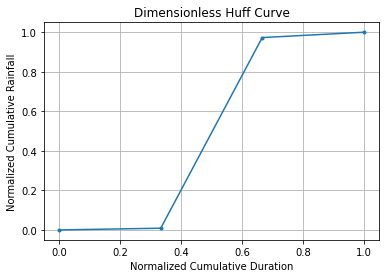

In [21]:
# Step 6: Plot the dimensionless Huff curve
plt.plot(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall, marker='.')
plt.xlabel('Normalized Cumulative Duration')
plt.ylabel('Normalized Cumulative Rainfall')
plt.title('Dimensionless Huff Curve')
plt.grid(True)
plt.show()

### See how long the event is

In [7]:
len(dimensionless_cumulative_rainfall)

32

### Steef method

In [8]:
def redistribute(array_in,len_out):
    len_in=len(array_in)
    # Array going from 0 up to and including the number of original points
    in_bounds=np.arange(len_in+1)
    # Calculates the total accumulated value at each original point
    # Adds a zero for point zero
    csum=np.cumsum(np.hstack((np.array([0.]),array_in)))
    # Array of the "time points" corresponding to
    # Boundaries of output intervals
    out_bounds=np.arange(len_out+1)*(len_in/(1.0*len_out))
    # Interpolate total accumulated value to desired output points
    csum_out=np.interp(out_bounds,in_bounds,csum)
    # Interpolate back to accumulations over the desired number of intervals
    array_out=csum_out[1:]-csum_out[:-1]
    return array_out

def redistribute_cumulative(cumulative_rainfall, len_out):
    len_in = len(cumulative_rainfall)
    
    # Array going from 0 up to and including the number of original points
    in_bounds = np.arange(len_in)
    
    # Array of the "time points" corresponding to boundaries of output intervals
    out_bounds = np.linspace(0, len_in-1, len_out)
    
    # Interpolate cumulative rainfall to the desired output points
    cumulative_out = np.interp(out_bounds, in_bounds, cumulative_rainfall)
    
    return cumulative_out

### Split into 12 equally spaced bins - using bin centres

In [31]:
nan_indices

array([False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True])

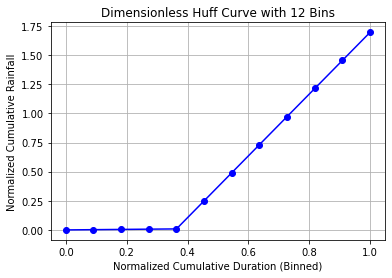

In [27]:
bins = np.linspace(0, 1, 13)  # 12 bins means 13 edges

#  Find within each of these bins each value falls
bin_indices = np.digitize(dimensionless_cumulative_duration, bins) - 1  # bin_indices from 0 to 11

# Initialize arrays for binned duration and rainfall
binned_duration = np.linspace(0, 1, 12)  # Midpoints of each bin
binned_rainfall = np.zeros(12)

# Fill in binned rainfall values by averaging values that fall into each bin
for i in range(12):
    indices_in_bin = np.where(bin_indices == i)[0]
    if len(indices_in_bin) > 0:
        binned_rainfall[i] = np.mean(dimensionless_cumulative_rainfall[indices_in_bin])
    else:
        binned_rainfall[i] = np.nan  # Mark empty bins with NaN for interpolation

# Step 8: Interpolate to fill in any empty bins (NaN values)
nan_indices = np.isnan(binned_rainfall)
interp_func = interp1d(binned_duration[~nan_indices], binned_rainfall[~nan_indices], kind='linear', fill_value="extrapolate")
binned_rainfall[nan_indices] = interp_func(binned_duration[nan_indices])

# Step 9: Plot the dimensionless Huff curve with 12 bins
plt.plot(binned_duration, binned_rainfall, marker='o', linestyle='-', color='b')
plt.xlabel('Normalized Cumulative Duration (Binned)')
plt.ylabel('Normalized Cumulative Rainfall')
plt.title('Dimensionless Huff Curve with 12 Bins')
plt.grid(True)
plt.show()

### Split into 12 equally spaced bins - using bin edges

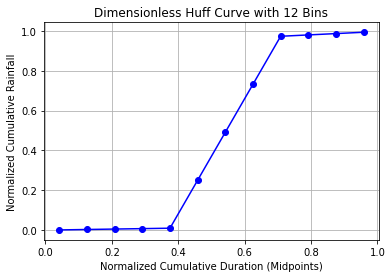

In [24]:
# Define 13 bin edges for 12 intervals (this includes a 0)
bins = np.linspace(0, 1, 13)  # 13 edges create 12 intervals

# Interpolate cumulative rainfall to the bin edges
# Includes a 0 and a 1 value, 13 values total
interp_func = interp1d(dimensionless_cumulative_duration, dimensionless_cumulative_rainfall, kind='linear', fill_value="extrapolate")
binned_rainfall_new = interp_func(bins)

# Step 8: Since we're working with cumulative data, calculate the midpoint of each bin for plotting
#binned_duration_new = (bins[:-1] + bins[1:]) / 2  # Midpoints of each bin interval

# Ensure no negative values in the rainfall data
# binned_rainfall_new = np.clip(binned_rainfall_new, a_min=0, a_max=None)

# Step 9: Plot the dimensionless Huff curve with 12 bins
plt.plot(binned_duration_new, binned_rainfall_new[:-1], marker='o', linestyle='-', color='b')
plt.xlabel('Normalized Cumulative Duration (Midpoints)')
plt.ylabel('Normalized Cumulative Rainfall')
plt.title('Dimensionless Huff Curve with 12 Bins')
plt.grid(True)
plt.show()


### Old method

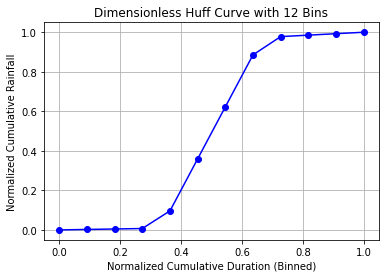

In [25]:
int_rainfall = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
plt.plot(binned_duration, int_rainfall, marker='o', linestyle='-', color='b')
plt.xlabel('Normalized Cumulative Duration (Binned)')
plt.ylabel('Normalized Cumulative Rainfall')
plt.title('Dimensionless Huff Curve with 12 Bins')
plt.grid(True)
plt.show()

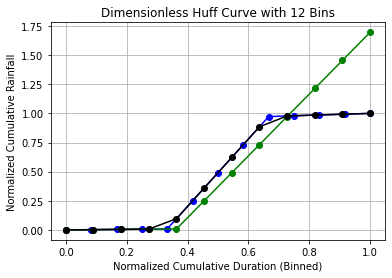

In [26]:
plt.plot(bins, binned_rainfall_new, marker='o', linestyle='-', color='b')
plt.plot(binned_duration, binned_rainfall, marker='o', linestyle='-', color='g')
plt.plot(binned_duration, int_rainfall, marker='o', linestyle='-', color='black')
plt.xlabel('Normalized Cumulative Duration (Binned)')
plt.ylabel('Normalized Cumulative Rainfall')
plt.title('Dimensionless Huff Curve with 12 Bins')
plt.grid(True)
plt.show()